In [ ]:
from IPython.display import clear_output
!pip install fredapi
!pip install myeia
clear_output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

from fredapi import Fred
api_key = "a98f1a6c0024e4c1e88b4aeac03bd09f"
fred = Fred(api_key)

from myeia.api import API
eia_api_key = "fgAgOxR7HrD3NiIBE9ciYOiAdfWTe82YmiRLZpl1"
eia = API(eia_api_key)

start_date = "1990-01-01"
end_date = "2024-01-01"

In [ ]:
def plot_curve(df, keys):
  size = len(keys)
  fig, axes = plt.subplots(nrows=(size+2) // 3, ncols=3, figsize=(15, (size + 2) // 3 * 3.5))
  r = 0
  c = 0
  for k in keys:
    axes[r,c].plot(df.index, df[k])
    axes[r,c].set_xlabel("Date")
    axes[r,c].set_ylabel(k)
    c += 1
    if c > 2:
      c = 0
      r += 1

## Step 3: Collect Data

### Crude Oil Price

In [ ]:
crude_oil_price = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])
crude_oil_price = crude_oil_price[(crude_oil_price.index >= start_date) & (crude_oil_price.index <= end_date)]

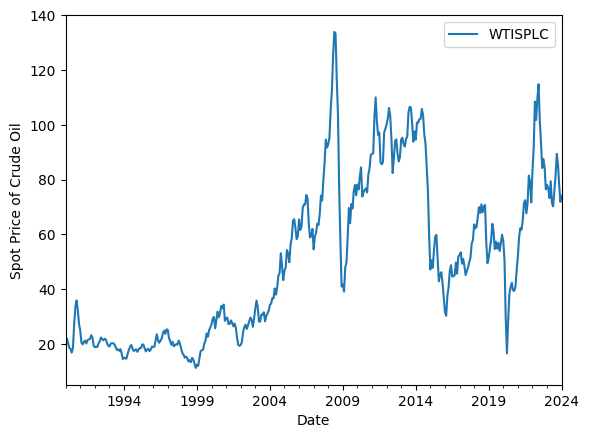

In [ ]:
crude_oil_price.plot()
plt.xlabel("Date")
plt.ylabel("Spot Price of Crude Oil");

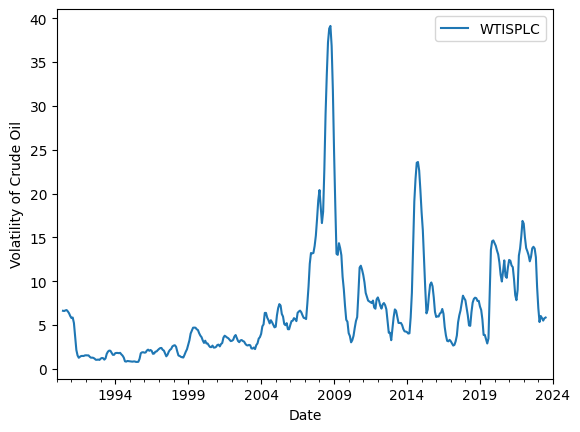

In [ ]:
crude_oil_price.rolling(12).std().shift(-6).plot();
plt.xlabel("Date")
plt.ylabel("Volatility of Crude Oil");

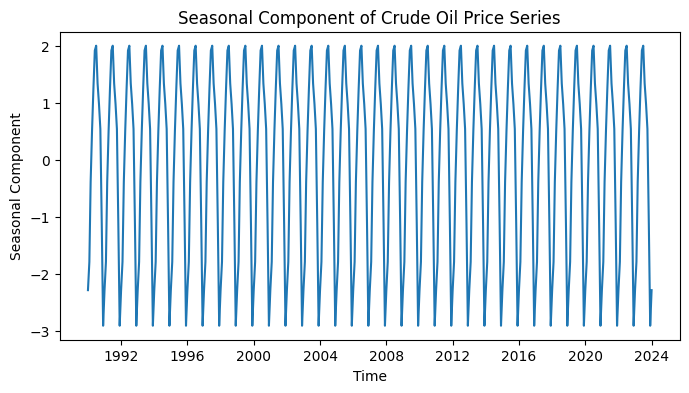

In [ ]:
# seasonal component
decomposition = sm.tsa.seasonal_decompose(crude_oil_price, model='additive')

seasonal_component = decomposition.seasonal
plt.figure(figsize=(8, 4))
plt.plot(seasonal_component)
plt.xlabel('Time')
plt.ylabel('Seasonal Component')
plt.title('Seasonal Component of Crude Oil Price Series')
plt.show()

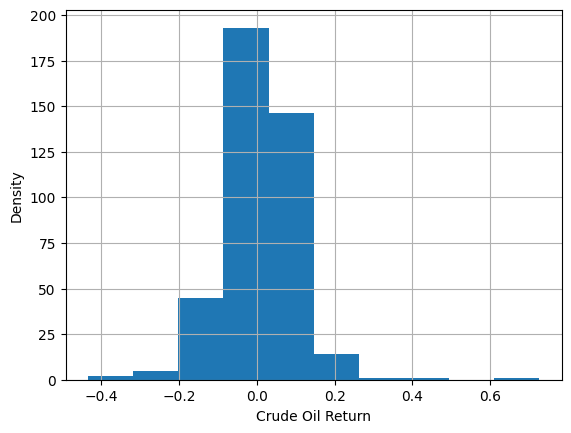

The data does not follow a normal-distribution.


In [ ]:
ret = crude_oil_price["WTISPLC"].pct_change().dropna()
ret.hist()
plt.xlabel("Crude Oil Return")
plt.ylabel("Density")
plt.show();

ret = ret.values
sample_mean = np.mean(ret)
sample_std = np.std(ret)
_, p_value = stats.shapiro(ret)
alpha = 0.05  # Significance level

if p_value > alpha:
    print("The data is normally distributed.")
else:
    print("The data does not follow a normal-distribution.")


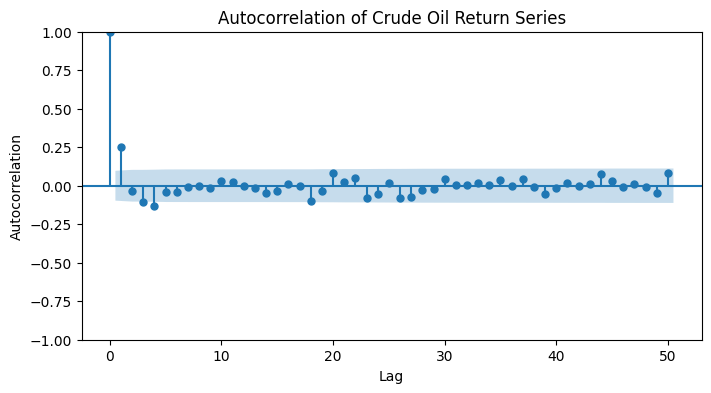

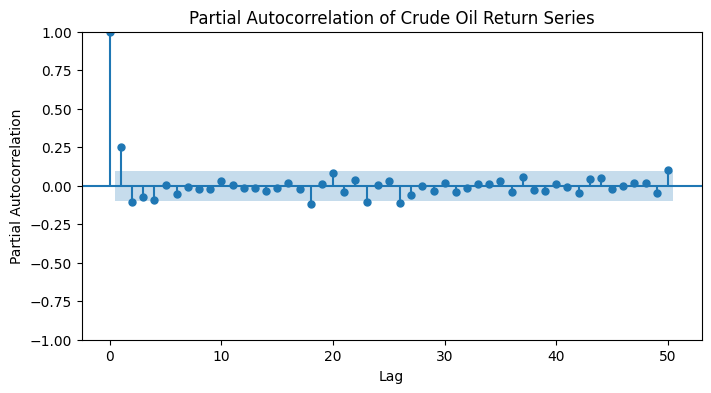

In [ ]:
# autocorrelation
fig, ax = plt.subplots(figsize=(8, 4))
tsaplots.plot_acf(ret, lags=50, alpha=0.05, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Crude Oil Return Series')
plt.show()

# partial autocorrelation
fig, ax = plt.subplots(figsize=(8, 4))
tsaplots.plot_pacf(ret, lags=50, alpha=0.05, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation of Crude Oil Return Series')
plt.show()

### 3.a Macroeconomic / geopolitical

In [ ]:
macro_dict = {
    "CPI_energy": "CPIENGSL",
    "CPI_total": "CPIAUCSL",
    "CAP_oil_gas": 'CAPG211S',
    "Util_oil_gas": 'CAPUTLG211S',
    "IP_oil_gas": 'IPG211S',
    "IP_crude_oil": 'IPG211111CN',
    "IP_total": 'INDPRO',
    "IP_drill_oil_gas": 'IPN213111N',
    "PPI_oil": 'PCU211211',
}

In [ ]:
macro = pd.DataFrame(fred.get_series("CPIENGSL"), columns=["CPI_energy"]).reset_index().rename(columns={"index": "Date"})
for k, v in macro_dict.items():
  if k == "CPI_energy": continue
  _df = pd.DataFrame(
      fred.get_series(v), columns=[k]
  ).reset_index().rename(columns={"index": "Date"})

  macro = macro.merge(_df, on="Date", how="left")

macro = macro.set_index("Date")
macro = macro[(macro.index >= start_date) & (macro.index <= end_date)]

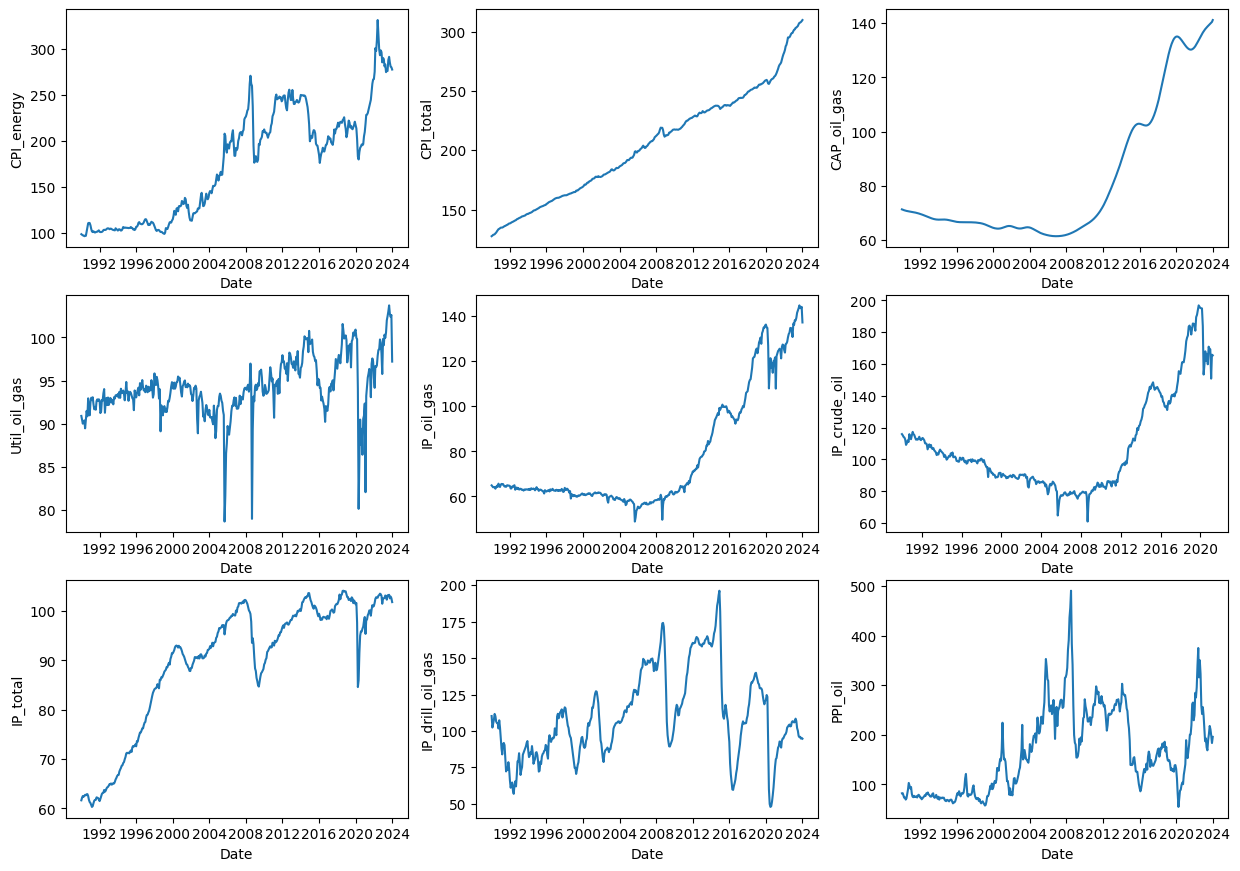

In [ ]:
plot_curve(macro, macro_dict.keys())

### 3.b Microeconomic

In [ ]:
micro_dict = {
    "crude_oil_inventory_OECD": "PASC_OECD_T3",
    "petroleum_supply_OPEC": "PAPR_OPEC",
    "fuel_consumption_OECD": "PATC_OECD",
    "fuel_consumption_non-OECD": "PATC_NON_OECD",
    "crude_oil_production_US": "COPRPUS",
    "crude_oil_refinery_input": "CORIPUS",
}

In [ ]:
micro = eia.get_series_via_route(
    route="steo",
    series=list(micro_dict.values()),
    frequency="monthly",
    facet="seriesId",
    start_date=start_date,
    end_date=end_date
)
micro = micro.sort_values(by='Date')
micro.columns = list(micro_dict.keys())
for col in micro.columns:
    micro[col] = micro[col].astype(float)

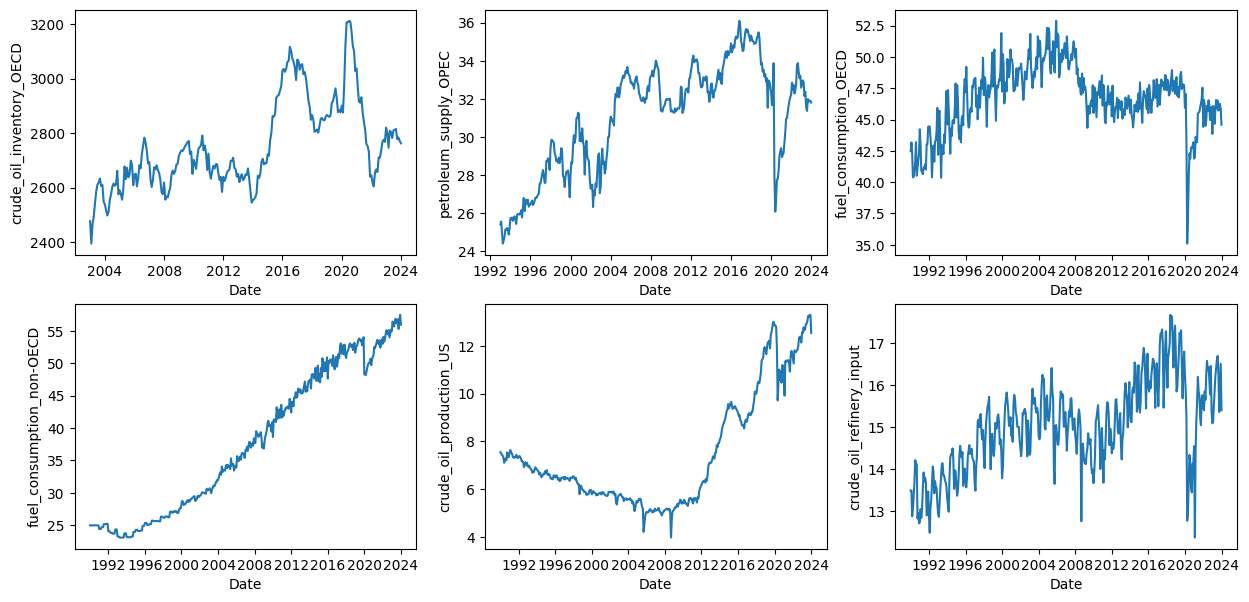

In [ ]:
plot_curve(micro, micro_dict.keys())

### 3.c Financial

In [ ]:
fin_dict = {
    "SP500": '^GSPC',
    "Dow": '^DJI',
    "Shell": 'SHEL',
    "Exxon": "XOM",
    "Chevron": "CVX",
    "BP": "BP",
 }

fin = yf.download(list(fin_dict.values()), start=start_date, end="2024-01-31")["Adj Close"]
fin.columns = fin_dict.keys()
fin = fin.resample("MS").mean()

[*********************100%%**********************]  6 of 6 completed


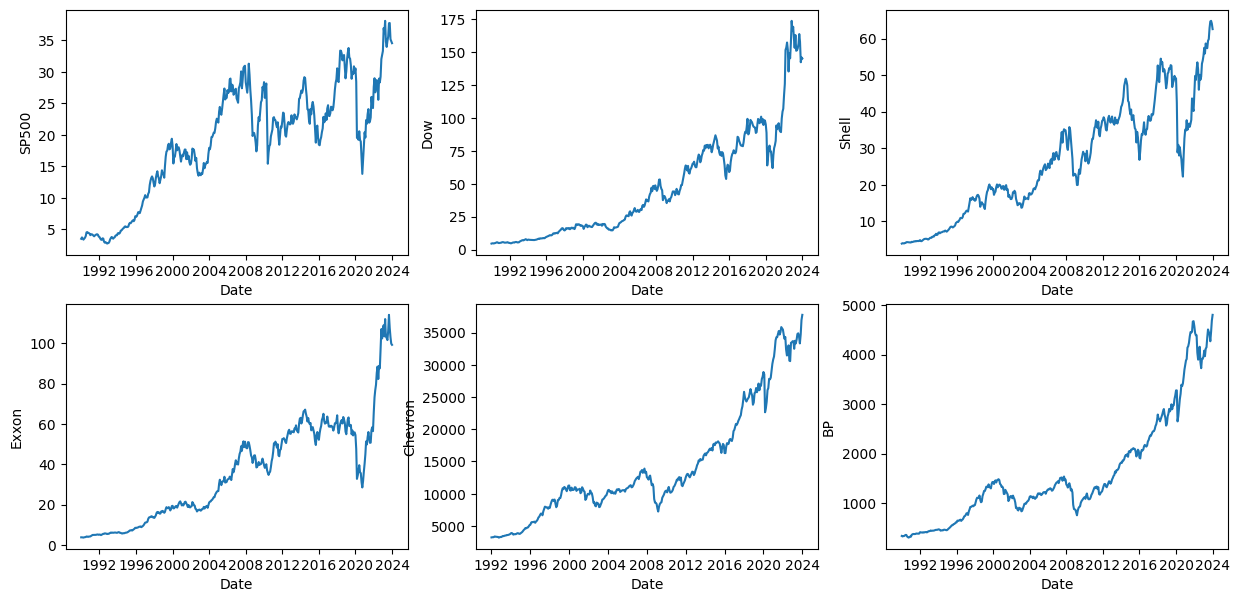

In [ ]:
plot_curve(fin, list(fin_dict.keys()))

In [ ]:
df = macro
df = df.reset_index().merge(micro.reset_index(), on="Date", how="left").set_index("Date")
df = df.reset_index().merge(fin.reset_index(), on="Date", how="left").set_index("Date")

## Step 5

### 5.a Extreme outlier

In [ ]:
def clear_outliers(df, n_std=3):
    # clip the data outside the lower and upper bounds
    lower_bound = df.mean() - n_std * df.std()
    upper_bound = df.mean() + n_std * df.std()

    df_cleaned = df.clip(lower=lower_bound, upper=upper_bound, axis=1)

    return df_cleaned

### 5.b Bad data

In [ ]:
def clean_bad_data(df):
    # Remove duplicated rows
    df_cleaned = df[~df.index.duplicated(keep='first')]
    return df_cleaned


### 5.c Missing Data


In [ ]:
def handle_missing_values(df):
    # interpolate the values and drop the rows if the features have no records
    df_cleaned = df.interpolate(method='linear', axis=0)
    df_cleaned = df_cleaned.dropna()
    return df_cleaned

In [ ]:
df = clear_outliers(df, 2)
df = clean_bad_data(df)
df = handle_missing_values(df)

## Step 7 EDA

### 7.a Distributional

In [ ]:
def plot_dist(df, keys):
  size = len(keys)
  fig, axes = plt.subplots(nrows=(size+2) // 3, ncols=3, figsize=(15, (size + 2) // 3 * 3.5))
  r = 0
  c = 0
  for k in keys:
    axes[r,c].hist(df[k], bins=30)
    axes[r,c].set_xlabel(k)
    axes[r,c].set_ylabel("Count")
    c += 1
    if c > 2:
      c = 0
      r += 1

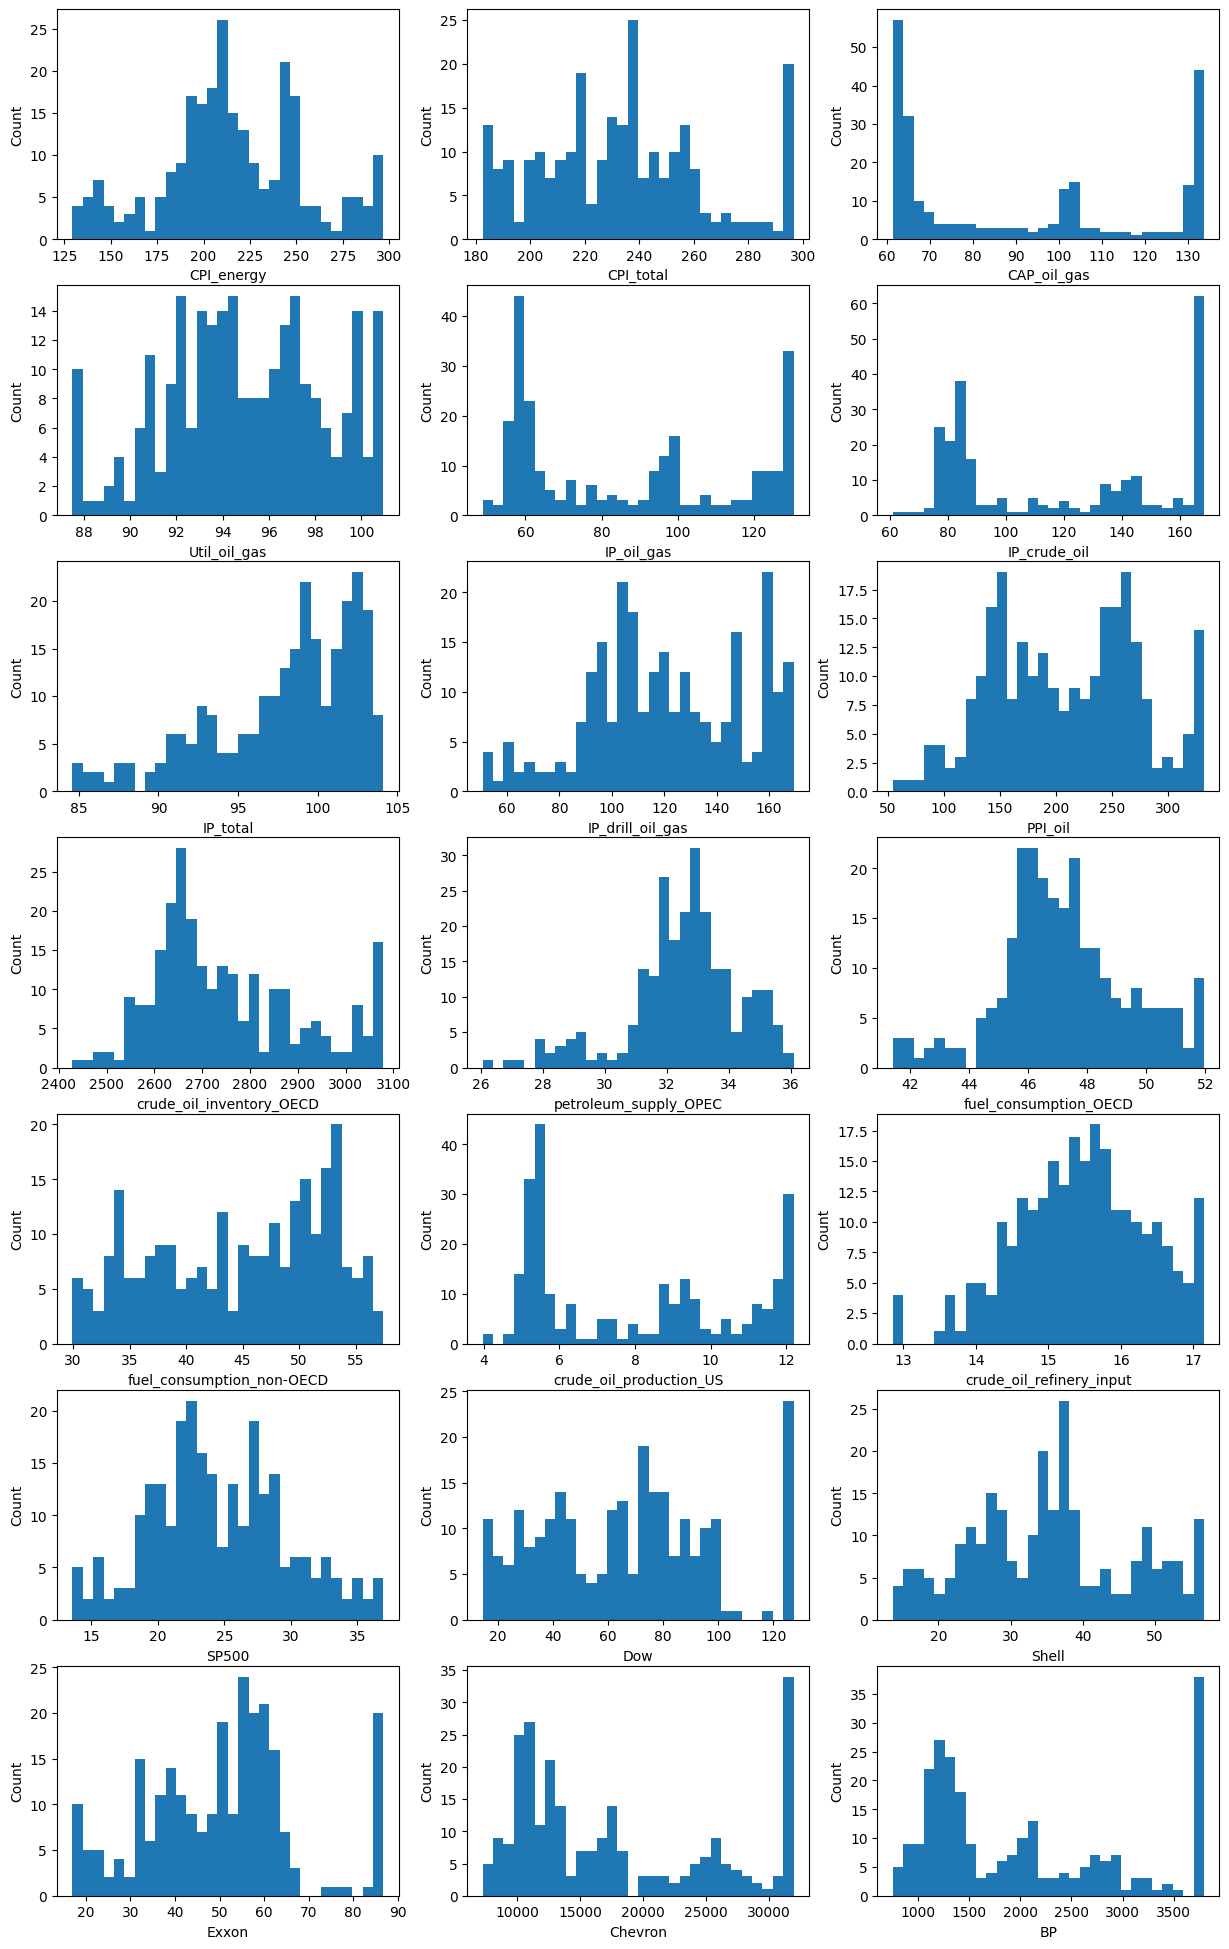

In [ ]:
plot_dist(df, df.columns)

### 7.b Time series

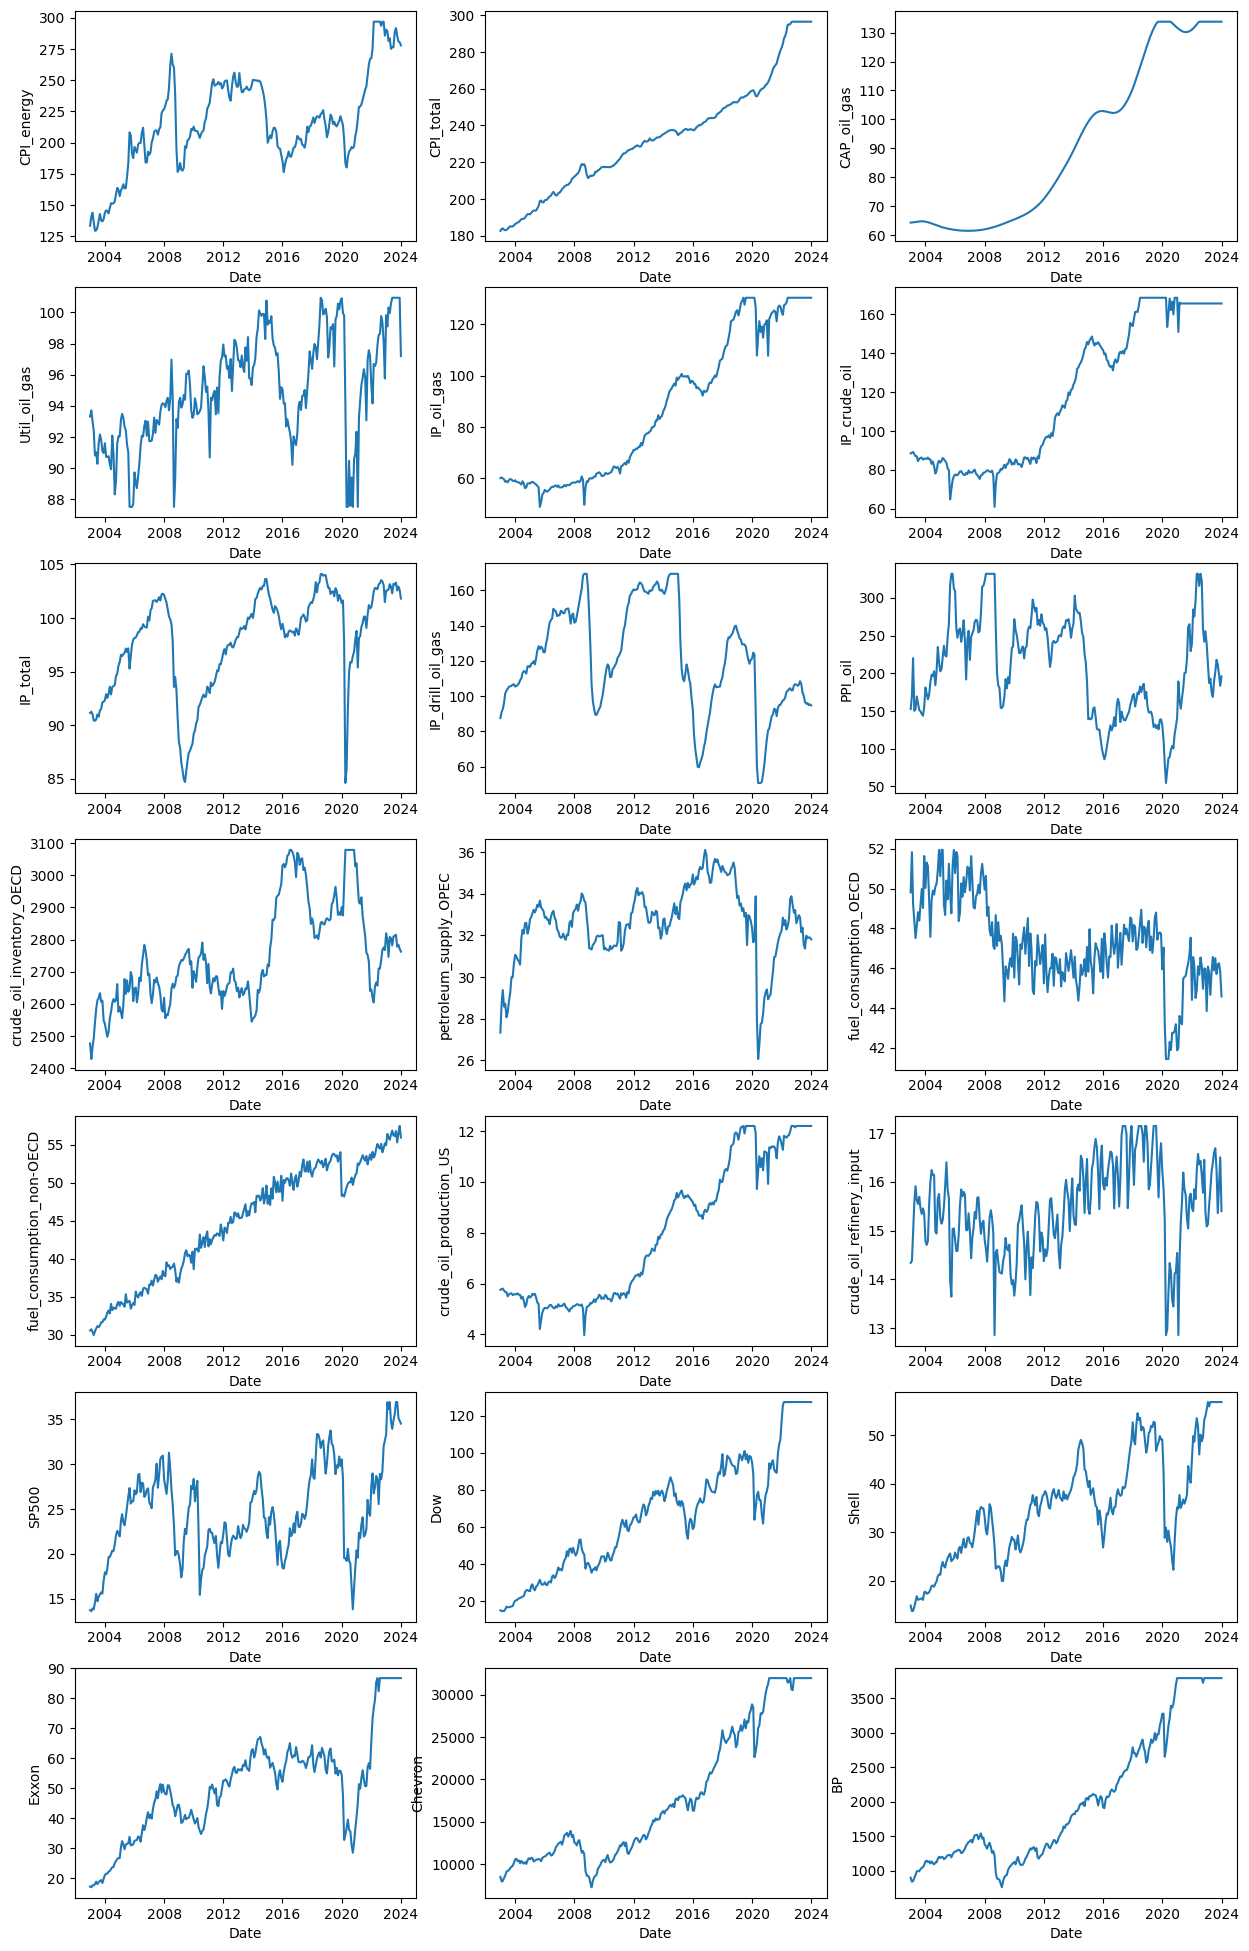

In [ ]:
plot_curve(df, list(df.columns))

In [ ]:
# # Function to plot time series for both macroeconomic and microeconomic data
# def plot_time_series(df_macro, df_micro):
#     # Plot time series for macroeconomic data
#     plt.figure(figsize=(12, 8))
#     for column in df_macro.columns:
#         plt.plot(df_macro.index, df_macro[column], label=column)
#     plt.title("Macroecnomic Time Series Plot")
#     plt.xlabel("Date")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Plot time series for microeconomic data
#     plt.figure(figsize=(12, 8))
#     for column in df_micro.columns:
#         plt.plot(df_micro.index, df_micro[column], label=column)
#     plt.title("Microeconomic Time Series Plot")
#     plt.xlabel("Date")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Call the function to plot time series for both macroeconomic and microeconomic data
# plot_time_series(macro_cleaned, micro_cleaned)


### 7.c Multivariate

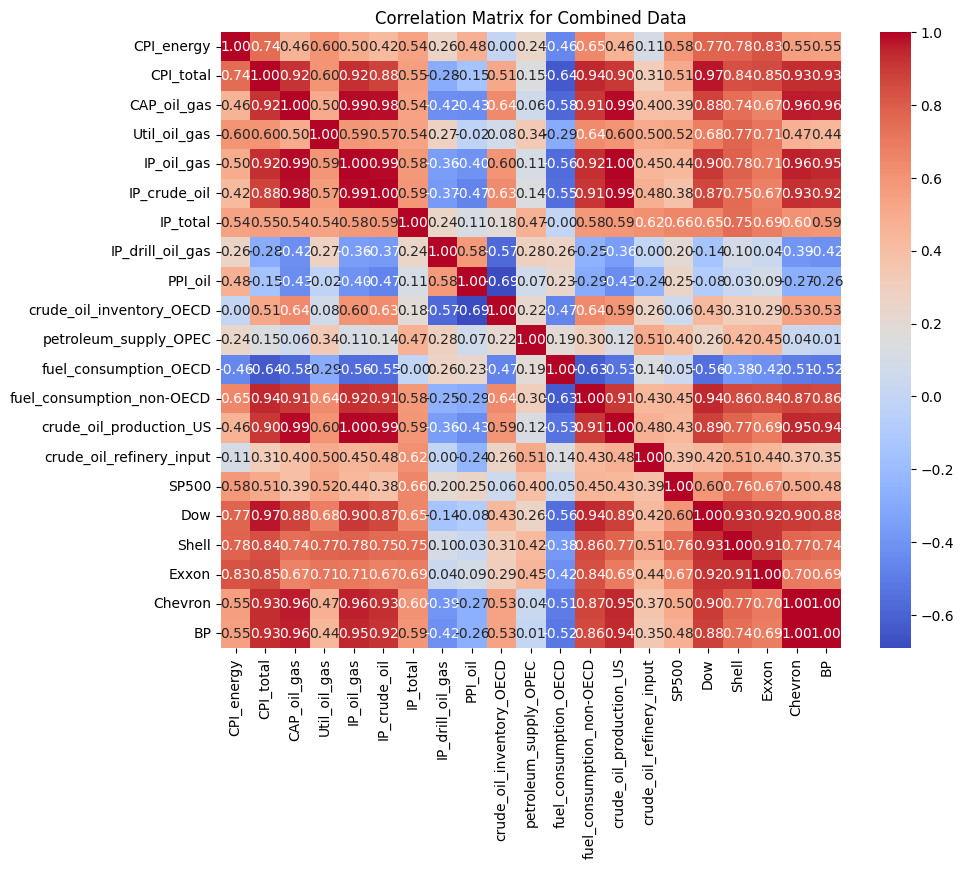

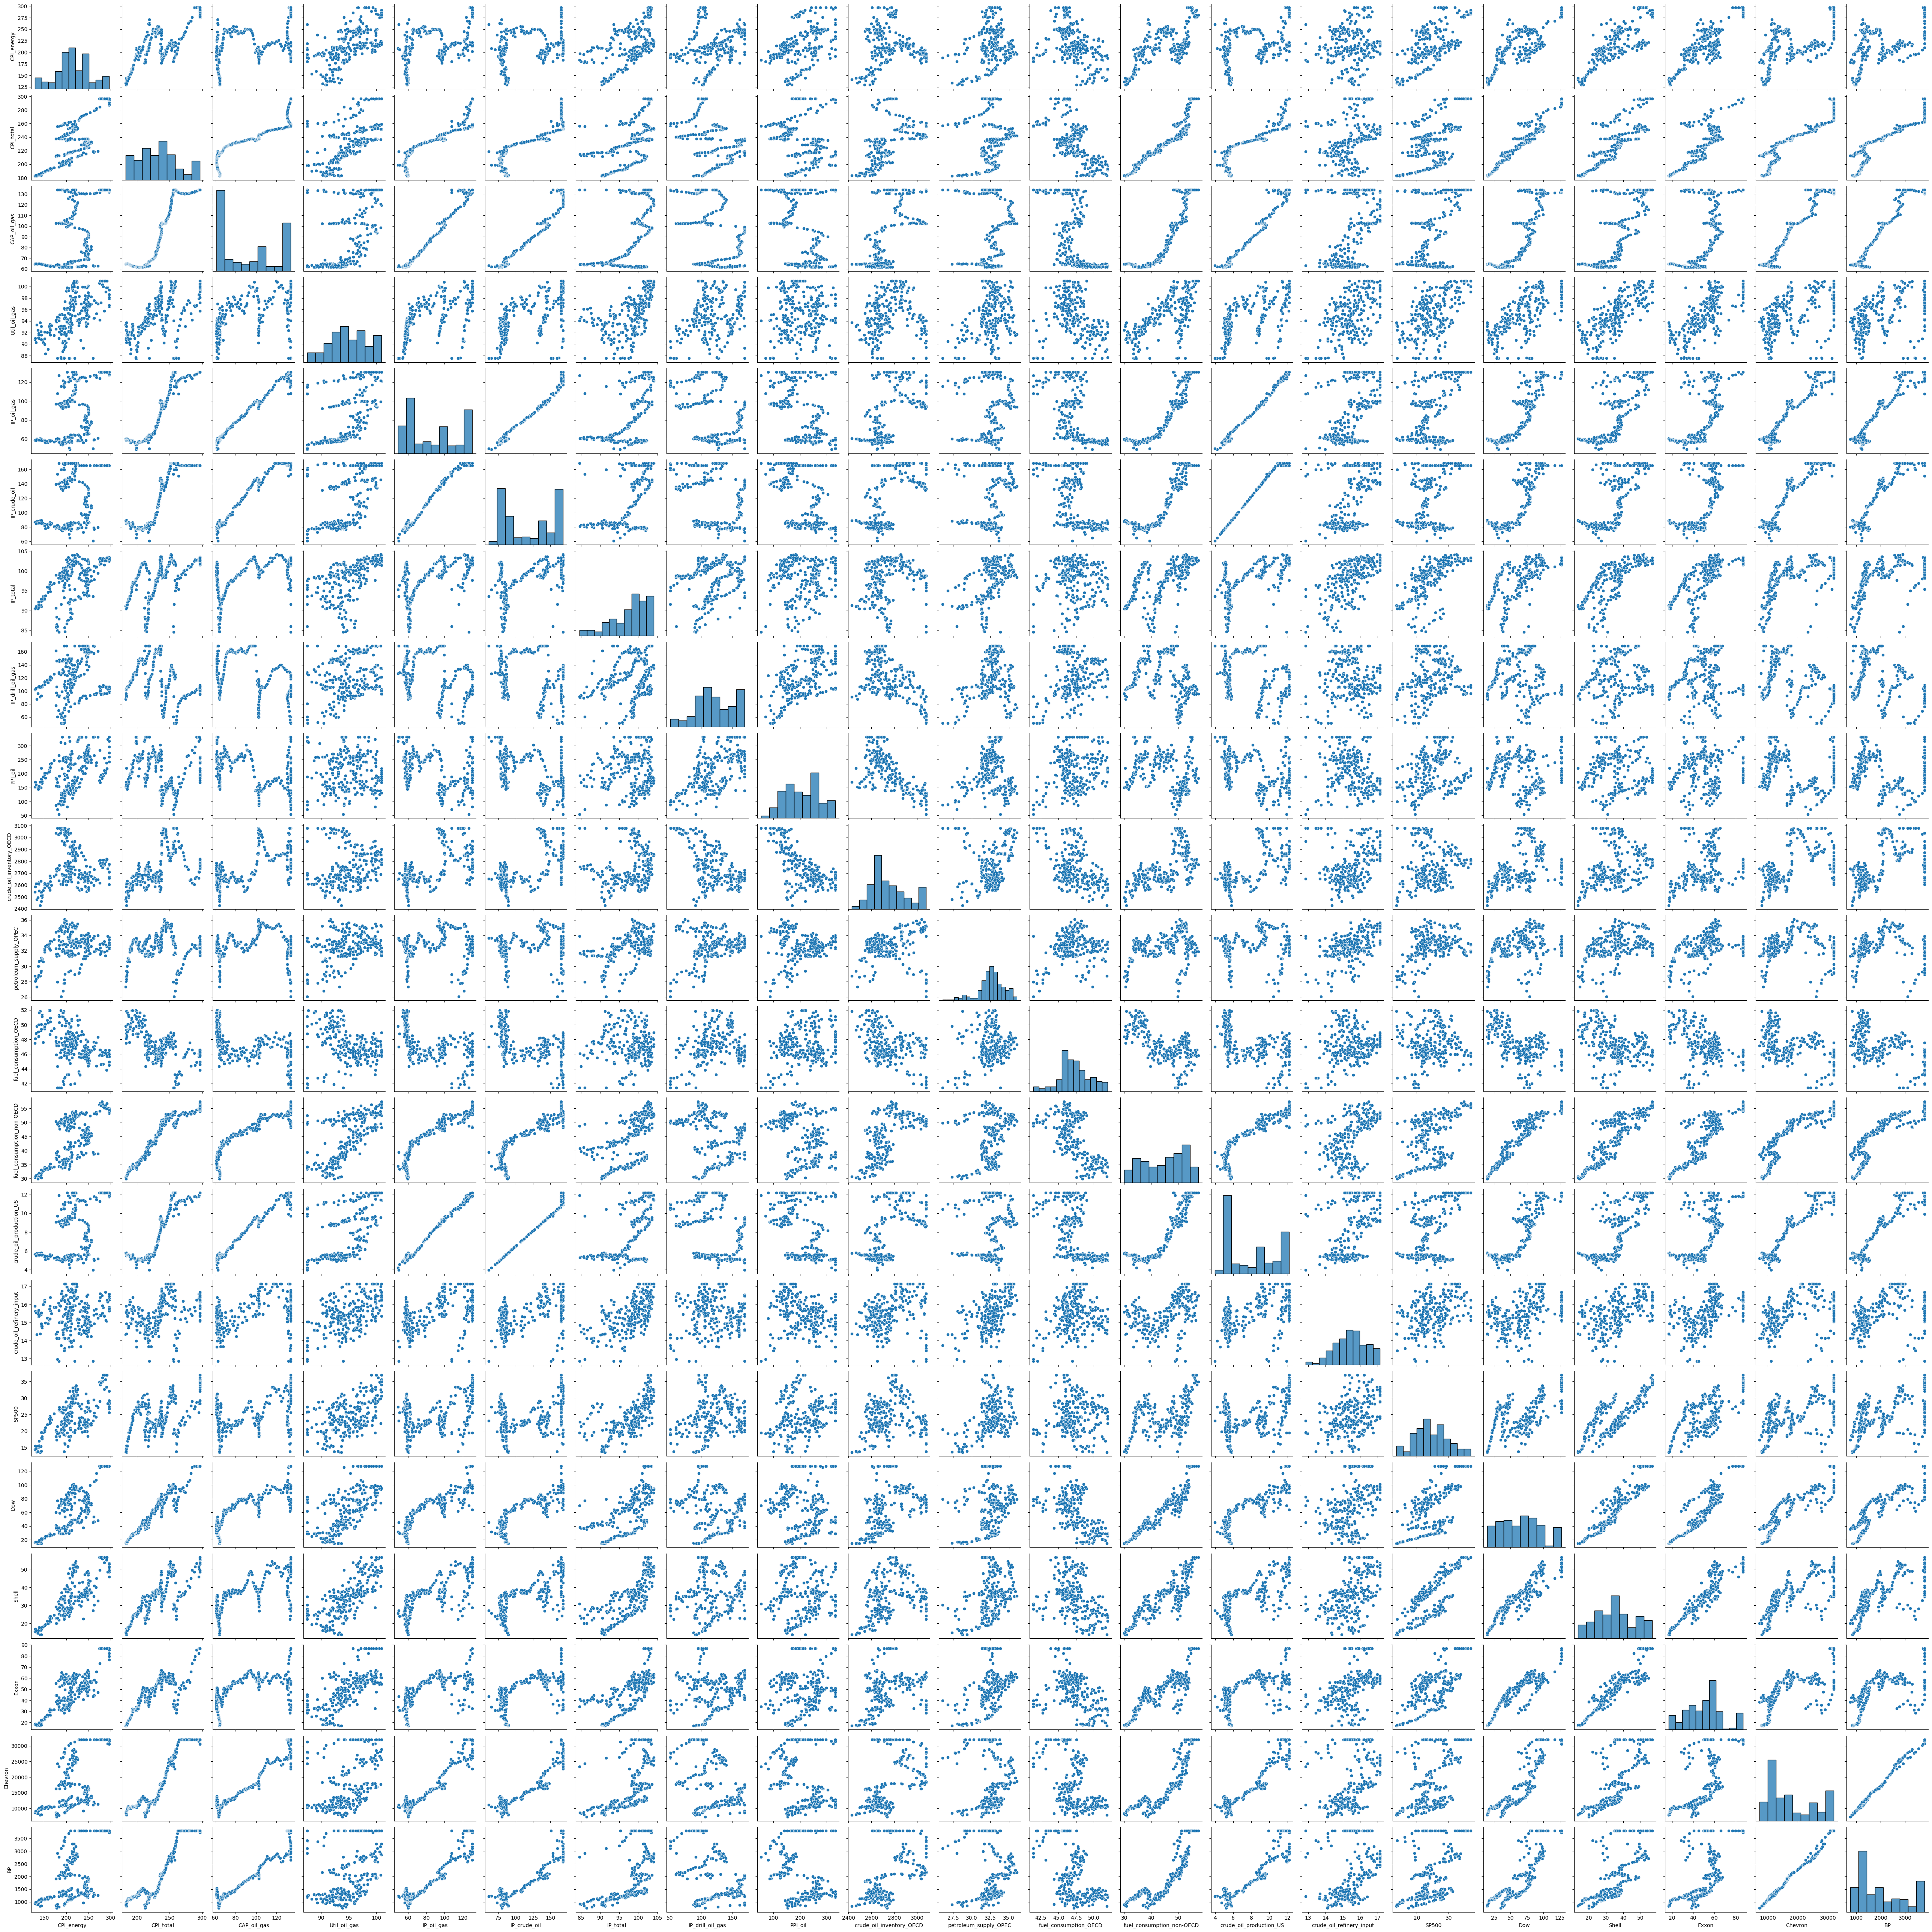

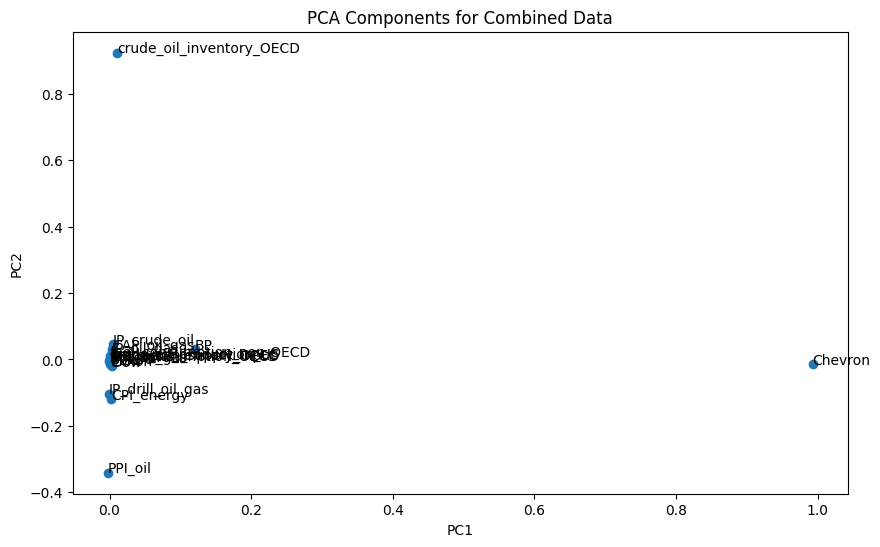

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA

# heatmap for correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Combined Data")
plt.show()

# Create a scatter plot matrix
sns.pairplot(df)
plt.show()

# PCA
pca = PCA(n_components=2)
pca.fit(df)

# Plot the PCA results
plt.figure(figsize=(15, 9))
plt.scatter(pca.components_[0, :], pca.components_[1, :])
for i, variable in enumerate(df.columns):
    plt.annotate(variable, (pca.components_[0, i], pca.components_[1, i]))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Components for Combined Data")
plt.show()

## Step 2,4,6,8-10: please refer to the report.